<a href="https://colab.research.google.com/github/unprintio/research-notebooks/blob/master/Background_removal_for_Photogrammetry_based_PointCloud_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

The vision of `unprint.io`, the next photogrammetry as a service platform, is to democratize high-quality 3D content creation.  This journey presents a lot of challenges for current the photogrammetry state of the art: it must be simple, easy, like current photography.

In order to have a nice 3D model to share, it is a must to do some post-processing.  At `unprint.io`, we believe that post-processing in photogrammetry must be eventually, reduced to zero, in order to reach the masses.

This notebook proposes an authentic method to *automatically clip* the result of photogrammetry pipeline (either a point-cloud or a mesh), aiming to replace this manual step by automation.

The technique described is based on the model's point-cloud and requires the cameras model as well, such as their positions, normals and intrinsic parameters.

_Author: Gerardo Bort_ <gerardobort@gmail.com>

# Proposed method

The routine proposed has certain preconditions that are out of this study:
* The photogrammetry model must be for an object rather than a scene.
* Best practices for photogrammetry photo acquisition should be followed.


There are some assumptions that need clarification before proceed:
* For object-oriented photogrammetry datasets, the cameras converge to a centroid.  The centroid's notion is the center of the object being captured.  This can be automatically estimated.  We've already proven this method with outstanding and robusts results.
* For these datasets, the pictures usually contains repetitive imaging of the background.  Often this result in 3D-mapped regions that are not of interest for the user. We pursue to ease the user's experience by fixing this for them (automatic clipping).
* The noise and outliers that are close to the model and not related to the background removal are out of scope of this method.



## Procedure

We will create a ConvexHull, not from the pointcloud, but from the cameras metadata.  We will use as source of points:
* The cameras position
* The cameras viewing frustum points (far-plane corner points):  These can be computed from the camera position, normal, focal length, and photo size.

Once created the ConvexHull, we filter out all the point-cloud outliers for that hull. And show the reuslts.

Note: this method can also be added in between the dense point step in the pipeline and the mesh generation.

## Installing dependencies

In [0]:
!pip install git+https://github.com/daavoo/pyntcloud
!pip install wget
!pip install pyquaternion

  Cloning https://github.com/daavoo/pyntcloud to /tmp/pip-req-build-l1u6hud1
  Stored in directory: /tmp/pip-ephem-wheel-cache-pdcc0xi3/wheels/be/37/76/afc097c015aa7cdb2ccfc317e1ea8684c387d6b48984dd1ded
Successfully built pyntcloud


## Preparing data

The datasets used here are taken from internal PHaaS test cases.  The PLY models are standard, meanwhile the cameras metadata JSON has a custom format.

### Download point-cloud model (PLY file)

In [0]:
from pyntcloud import PyntCloud
import os.path
import wget

"""
# angel dataset
url_ply = 'https://storage.googleapis.com/phaas-assets-1/jobs/5c7174c19f02c200102c8dde/sparse_refined_aligned.ply'
filename = 'sparse_refined_aligned.ply'
url_metadata = 'https://storage.googleapis.com/phaas-assets-1/jobs/5c7174c19f02c200102c8dde/metadata.json'
"""

# aperol bike dataset (found at La Alacena, Buenos Aires) - https://www.google.com.ar/maps/@-34.5941556,-58.4227228,3a,75y,28.69h,81.1t/data=!3m6!1e1!3m4!1sxFA1e0T0rHKFLeqdQbAFAw!2e0!7i13312!8i6656
url_ply = 'https://storage.googleapis.com/phaas-assets-1/jobs/5bb9542c64960c001044da12/sparse_refined_dense_mesh_refine_texture_aligned.ply'
filename = 'sparse_refined_dense_mesh_refine_texture_aligned.ply'
url_metadata = 'https://storage.googleapis.com/phaas-assets-1/jobs/5bb9542c64960c001044da12/metadata.json'

if not os.path.isfile(filename):
  wget.download(url_ply)

model = PyntCloud.from_file(filename)

# extract only x,y,z values
ply_points = model.points.values[:,0:3]
display(ply_points)

array([[-4.056034  ,  5.0326166 , -8.141059  ],
       [-3.1728108 ,  0.43517345, -2.0825207 ],
       [-3.1893737 ,  0.45754334, -2.0918086 ],
       ...,
       [-0.24673061,  0.67745286,  1.9239393 ],
       [-0.24493885,  0.68444496,  1.9138179 ],
       [-0.255189  ,  0.68370277,  1.9181284 ]], dtype=float32)

As can be seen in the following figure, the raw point-cloud, as result of an automated photogrammetry pipeline, contains lot of outlier points that are not part of the bike.

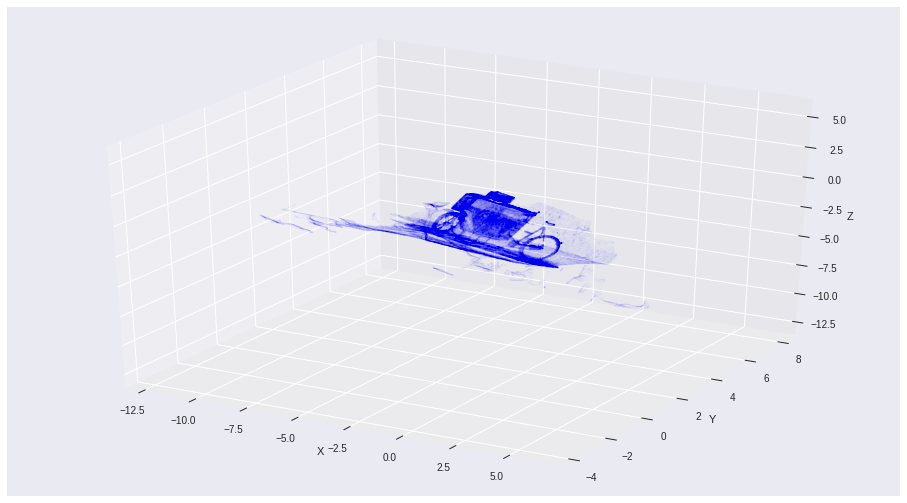

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ply_points[:, 0], ply_points[:, 1], ply_points[:, 2], s=1, c='b', alpha=0.01)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Download cameras model

In [0]:
import requests
import json
import numpy as np

source = requests.get(url_metadata).content  
data = json.loads(source)
# display(data)

camera_points = np.array([np.array(camera['tvec']) for camera in data['cameras']])

## Procedure

### Compute the cameras points of interest (aligned center, and far-plane)

In [0]:
from pyquaternion import Quaternion

def get_camera_info(camera):
  """
  This method converts the given metadata values into aligned cameras position
  and far-plane points (targets).
  """
  q = Quaternion(camera['qvec'])
  R = q.rotation_matrix
  R_t = -np.transpose(R)
  T = camera['tvec']
  position = np.matmul(R_t, T)

  
  # this is the xy square around the position center that will
  # get rotated into the direction
  w = 1 * camera['width'] / 1024.0
  h = w * camera['height'] / camera['width']
  normals_xy = [
      [0, 0], # normal
      [-w/2, -h/2],
      [ w/2,  h/2],
      [ w/2, -h/2],
      [-w/2,  h/2],
  ]
  
  targets = []
  for xy in normals_xy:
    fl = np.array([xy[0], xy[1], camera['distance']])
    camera_target = np.matmul(R_t, T - fl)
    position_to_target = np.subtract(camera_target, position)
    normal = position_to_target / np.linalg.norm(position_to_target)
    targets.append(position_to_target + normal)

  return {
    'position': position,
    'targets': position + targets,
  }

### Plot cameras calculated elements

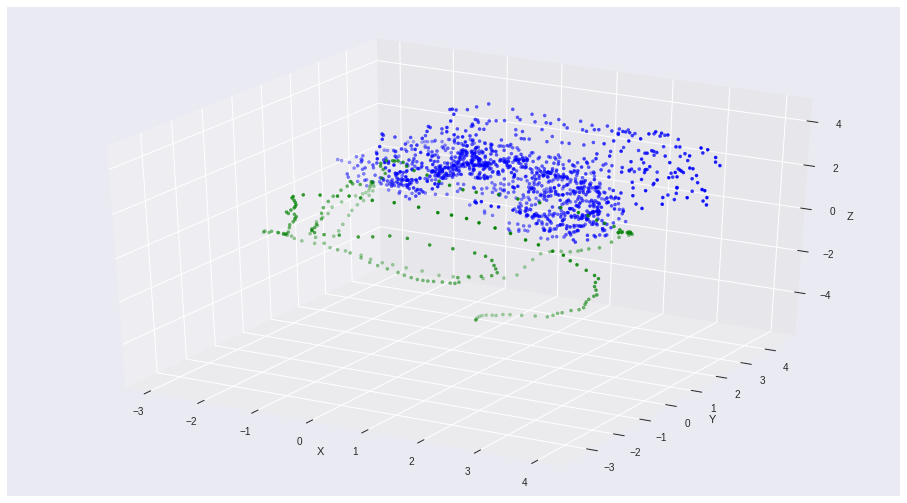

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

cameras = list(map(get_camera_info, data['cameras']))
camera_positions = np.array(list(map(lambda c: c['position'], cameras)))
camera_targets = np.array(list(map(lambda c: c['targets'], cameras))).flatten().reshape((len(cameras)*5,3))

points = np.concatenate([camera_positions, camera_targets])

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

# plot in green the cameras position
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], s=10, c='g')

# plot in blue the cameras far-plane points
ax.scatter(camera_targets[:,0], camera_targets[:,1], camera_targets[:,2], s=10, c='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Find and plot ConvexHull wrapping points

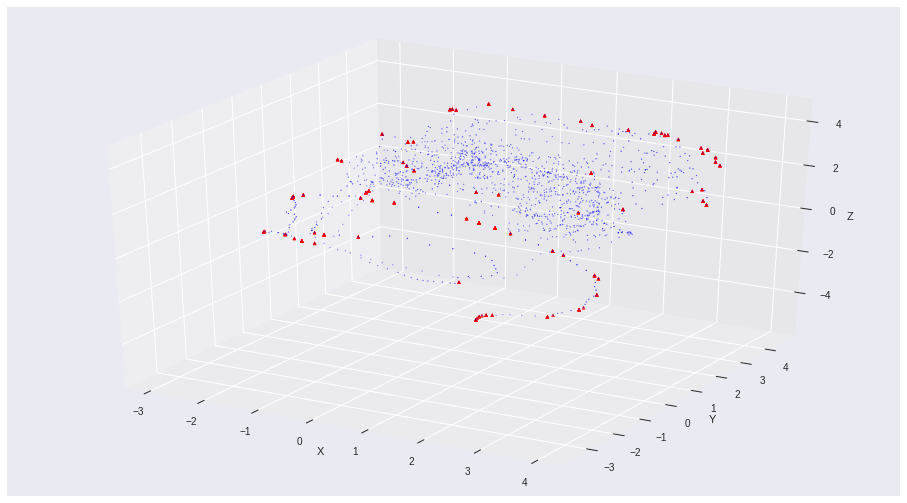

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

# inliers
inliers = np.concatenate([camera_positions, camera_targets])

# plot in blue the cameras points (all positions and far-plane points)
ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], s=1, c='b')

# create a convex-hull
hull = ConvexHull(inliers)
for simplex in hull.simplices:
  # plot in red the srhinkwrap points for the convex-hull
  ax.scatter(inliers[simplex, 0], inliers[simplex, 1], inliers[simplex, 2], s=10, c='r', marker='^')
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Filter points using ConvexHull

In [0]:
def is_in_hull(P, hull):
    '''
    https://stackoverflow.com/questions/21698630/how-can-i-find-if-a-point-lies-inside-or-outside-of-convexhull
    Datermine if the list of points P lies inside the hull
    :return: list
    List of boolean where true means that the point is inside the convex hull
    '''
    A = hull.equations[:,0:-1]
    b = np.transpose(np.array([hull.equations[:,-1]]))
    return np.all((A @ np.transpose(P)) <= np.tile(-b,(1,len(P))),axis=0)

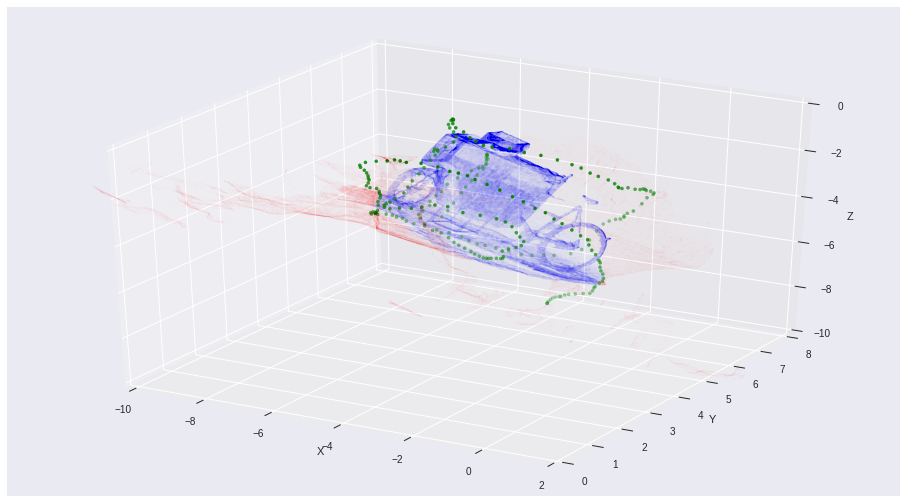

In [0]:
# remove inner points
mask = is_in_hull(ply_points, hull)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

inliers = ply_points[ mask ]
outliers = ply_points[ ~mask ]

# plot in blue the inlier points
ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], s=1, c='b', alpha=0.01)

# plot in red the outlier points
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], s=1, c='r', alpha=0.01)

# plot in green the camera position points
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], s=10, c='g')
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-10, 2)
ax.set_ylim(0, 8)
ax.set_zlim3d(-10, 0)

plt.show()